In [1]:
from adblockparser import AdblockRules
import tldextract
import re
import collections
# import matplotlib
import matplotlib.pyplot as plt
import os, fnmatch

In [2]:
partner_dictionary = {}

def adblockparser_parse(rule_list):
    return AdblockRules(rule_list)

def return_domain(rule_line):
    rule = []
    rule.append(rule_line)
    easylist_adblock_rules = adblockparser_parse(rule)
    domain = ''

    # print("rule list ----->", rule)
    # print("Value of r ---->", easylist_adblock_rules.rules)
    for r in easylist_adblock_rules.rules:
        y = r.rule_text
        x = y
        if x[:2] == '||':
            if '^' in x:
                split = x.index("^")
                x = x[2:split]
            else:
                x = x[2:]
        elif x[:1] =='|':
            x = x[1:]

        # print("from return domain -->",x)
        domain = tldextract.extract(x).domain

    return domain

def check_if_valid_domain(hostname):
    if len(hostname) > 255:
        return False
    hostname = hostname.rstrip(".")
    allowed = re.compile('^[a-z0-9]([a-z0-9\-\_]{0,61}[a-z0-9])?$',
                         re.IGNORECASE)
    labels = hostname.split(".")

    # the TLD must not be all-numeric
    if re.match(r"^[0-9]+$", labels[-1]):
        return False

    return all(allowed.match(x) for x in labels)

def extract_partner_domain():

    global partner_dictionary
    partner_count_not_unique = 0

    with open('processed-dec-2019-exceptionrules-latest.txt') as fexception:
        partner = ''
        domain=''
        for line in fexception:
            line = line.rstrip()

            
            if line[0] == '[':
                partner_count_not_unique+=1
                partner = line[1:-1]
                if partner not in partner_dictionary.keys():
                    partner_dictionary.update({partner:{'collaborators':[],'surrogate':[]}})

            if 'sitekey' in line:  # sitekey coz tld couldnt parse with sitekey in options
                split = line.index("sitekey")
                line = line[:split]
                # print("Line cut 1--->",line)
                if line[-1] == '$' or line[-1] ==',':
                    line = line[:-1]
                # print("Line cut 2---->",line)

            if '#@#' or '###' in line:
                split=-1
                if '#@#' in line:
                    split = line.index("#@#")
                if '###' in line:
                    split = line.index("###")

                if split >0:
                    line = line[:split]
                    # print("Line cut 3--->",line)

            if line[0] != '[':
                domain = return_domain(line)
                if check_if_valid_domain(domain) == False:
                    continue
                else:
                    partner_dictionary[partner]['collaborators'].append(domain)

            if line.find("$") >= 0 and partner != '':
                if (check_if_valid_domain(return_domain(line))) != False:
                    option_separator_index = line.find("$")
                    options_list = line[option_separator_index + 1:]
                    while options_list != "":
                        option_full = ""
                        split = options_list.index(",") if "," in options_list else -1
                        if split == -1:
                            option_full = options_list
                            options_list = ""
                        else:
                            option_full = options_list[:split]
    

                        list_exists = option_full.index("=") if "=" in option_full else -1

                        # case when lists are present - domain, sitekey cases
                        if list_exists != -1:
                            option_name = option_full[:list_exists]
                            if option_name == 'domain':
                                option_full = option_full[list_exists + 1:]
                                while option_full != "":
                                    next_index = option_full.index("|") if "|" in option_full else -1

                                    # case when there are no more lists present
                                    if next_index == -1:
                                        if option_full[0] == '~':
                                                option_full=option_full[1:]
                                                partner_dictionary[partner]['surrogate'].append(return_domain(option_full))
                                        else:
                                            partner_dictionary[partner]['surrogate'].append(return_domain(option_full))

                                        option_full = ""

                                    # case when there are options present in list
                                    else:

                                        curr_option = option_full[:next_index]
                                        if curr_option[0] == '~':
                                            curr_option = curr_option[1:]
                                            partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                        else:
                                            partner_dictionary[partner]['surrogate'].append(return_domain(curr_option))
                                        option_full = option_full[next_index + 1:]

                        options_list = options_list[split + 1:]
    print("Partner count -->",partner_count_not_unique)
                    
                        
extract_partner_domain()


    # print(partner_dictionary)

# with open('partner-collaborator.txt','w') as f:
#     for partner,partner_details in partner_dictionary.items():
#         f.write('partner------>'+partner)
#         f.write('\n')
#         for partner_type ,partner_list in partner_details.items():
#             f.write("partner type ----->"+partner_type)
#             for item in partner_list:
#                 f.write('\n')
#                 f.write(item)
#             f.write('\n')

Partner count --> 702


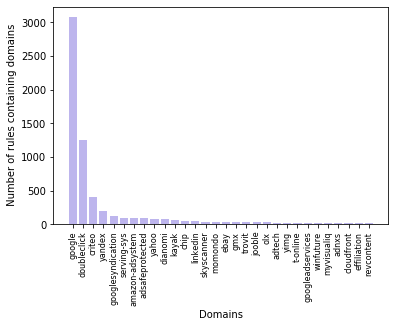

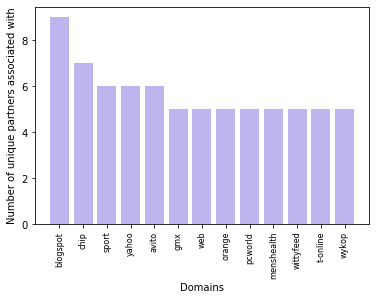

In [4]:
def graph_gen():
    global partner_dictionary

    # get all the collaborators
    
#     font = {'family': 'Liberation Serif',
#         'weight' : 'normal',
#         'size'   : 15
#        }
    
#     matplotlib.rcParams['axes.titlesize'] = 20
#     matplotlib.rcParams['axes.labelsize'] = 15  
#     matplotlib.rc('font', **font)
#     matplotlib.rcParams['text.usetex'] = True
#     matplotlib.rcParams['pdf.fonttype']= 42
#     matplotlib.rcParams['pdf.use14corefonts']=True

    l=[]
    for key in partner_dictionary.keys():
        l.extend(partner_dictionary[key]['collaborators'])

    w = collections.Counter(l)

    w_dup ={}

    listofTuples = sorted(w.items(), key=lambda x: x[1], reverse=True)

    for elem in listofTuples:
        if elem[1] >20:
            w_dup.update({elem[0]:elem[1]})
#     print(w_dup)
    plt.xticks(range(len(w_dup.keys())), w_dup.keys(), rotation=90, fontsize=8)
    plt.bar(list(w_dup.keys()), list(w_dup.values()),color='#BDB5ED')
    plt.xlabel('Domains')
    plt.ylabel(' Number of rules containing domains')
#     plt.tight_layout()
#     plt.savefig('surrogate_domains.pdf')
#     plt.savefig('surrogate_domains.pdf', format='pdf', dpi=1200)
    plt.show()
    
    
    # map surrogate domains with number of partners
    
    s = {}
    
    for partner in partner_dictionary.keys():
        for surrogate_domain in partner_dictionary[partner]['surrogate']:
            if surrogate_domain in s.keys():
                s[surrogate_domain][0].add(partner)
            else:
                s.update({surrogate_domain:[set(),0]})
                s[surrogate_domain][0].add(partner)
                
    for domain in s:
        s[domain][1] = len(s[domain][0])

#     print(s)
    
    w={}

    for domain in s:
        w.update({domain:s[domain][1]})
    
    listofTuples = sorted(w.items(), key=lambda x: x[1], reverse=True)
        
    w_dup={}
    for elem in listofTuples:
        if elem[1] >4:
            w_dup.update({elem[0]:elem[1]})
#     print(w_dup)

    


    
    
    plt.xticks(range(len(w_dup.keys())), w_dup.keys(), rotation=90, fontsize=8)
    plt.bar(list(w_dup.keys()), list(w_dup.values()),color='#BDB5ED')
    plt.xlabel('Domains')
    plt.ylabel('Number of unique partners associated with')
#     plt.tight_layout()
#     plt.savefig('surrogate_domains.pdf')
#     plt.savefig('surrogate_domains.pdf', format='pdf', dpi=1200)
    plt.show()
    
    


graph_gen()